### Importamos librerias

In [1]:
import implicit
import numpy as np
import pandas as pd
import scipy.sparse as sp
from implicit.evaluation import ranking_metrics_at_k


c:\Users\leopo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Importe y Analisis del Dataset

In [ ]:
# Install dependencies as needed:
import kagglehub

path = kagglehub.dataset_download("mkechinov/ecommerce-behavior-data-from-multi-category-store")

print("Path to dataset files:", path)

c:\Users\Tomás Goas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 4.29G/4.29G [02:11<00:00, 34.9MB/s]

Extracting files...


Path to dataset files: C:\Users\Tomás Goas\.cache\kagglehub\datasets\mkechinov\ecommerce-behavior-data-from-multi-category-store\versions\8


In [2]:
from pathlib import Path

src = Path("2019-Nov.csv")
dst = Path("2019-Nov-half.csv")
chunk_size = 200000
p = 0.25

first = True
rng = np.random.default_rng(42)
with pd.read_csv(src, chunksize=chunk_size, iterator=True) as reader:
    for chunk in reader:
        mask = rng.random(chunk.shape[0]) < p
        sub = chunk[mask]
        if first:
            sub.to_csv(dst, index=False, mode='w')
            first = False
        else:
            sub.to_csv(dst, index=False, header=False, mode='a')
print('Wrote', dst)

Wrote 2019-Nov-half.csv


In [2]:
df = pd.read_csv("2019-Nov-half.csv")
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2
1,2019-11-01 00:00:02 UTC,view,12708937,2053013553559896355,NaN,michelin,72.72,532364121,0a899268-31eb-46de-898d-09b2da950b24
2,2019-11-01 00:00:06 UTC,view,24900193,2053013562183385881,NaN,NaN,1.09,512651494,f603c815-f51a-46fe-9404-cb586e35edaf
3,2019-11-01 00:00:07 UTC,view,5100503,2053013553375346967,NaN,xiaomi,22.68,520037415,f54fa96a-f3f2-43ac-99a4-fcb2a449dd36
4,2019-11-01 00:00:09 UTC,view,26019863,2053013562837697343,NaN,NaN,11.79,566280860,341a87d8-8cf4-4b4a-8b7d-749380697af1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16875399 entries, 0 to 16875398
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.1+ GB


## Data Analysis

Veo que tipos de eventos contiene el dataset

In [7]:
print(df['event_type'].unique())

print(df['event_type'].value_counts())

['view' 'cart' 'purchase']
event_type
view        28599767
cart         1068132
purchase      332101
Name: count, dtype: int64


In [8]:
# Conteo de cada tipo de evento
event_counts = df['event_type'].value_counts()
print(event_counts)

# Con porcentajes
event_percentages = df['event_type'].value_counts(normalize=True) * 100
print(event_percentages)

event_type
view        28599767
cart         1068132
purchase      332101
Name: count, dtype: int64
event_type
view        95.332557
cart         3.560440
purchase     1.107003
Name: proportion, dtype: float64


=== ANÁLISIS DE CATEGORÍAS ===
Columna de categoría usada: category_code

Total de categorías únicas: 126

Top 15 categorías más populares:
category_code
electronics.smartphone              7583714
computers.notebook                  1002462
electronics.video.tv                 985645
electronics.clocks                   885071
apparel.shoes                        808661
electronics.audio.headphone          760912
appliances.kitchen.washer            646084
appliances.environment.vacuum        644256
appliances.kitchen.refrigerators     643675
computers.desktop                    324908
furniture.living_room.cabinet        269928
furniture.bedroom.bed                243240
apparel.shoes.keds                   242665
auto.accessories.player              222823
electronics.tablet                   217005
Name: count, dtype: int64

Total de categorías únicas: 126

Top 15 categorías más populares:
category_code
electronics.smartphone              7583714
computers.notebook                 

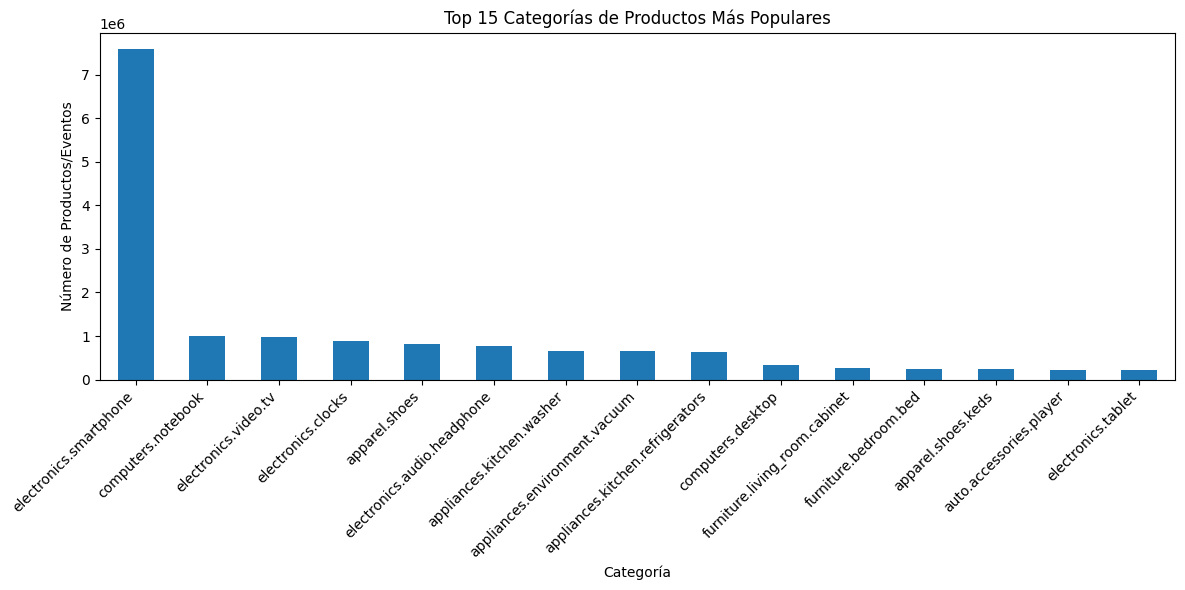

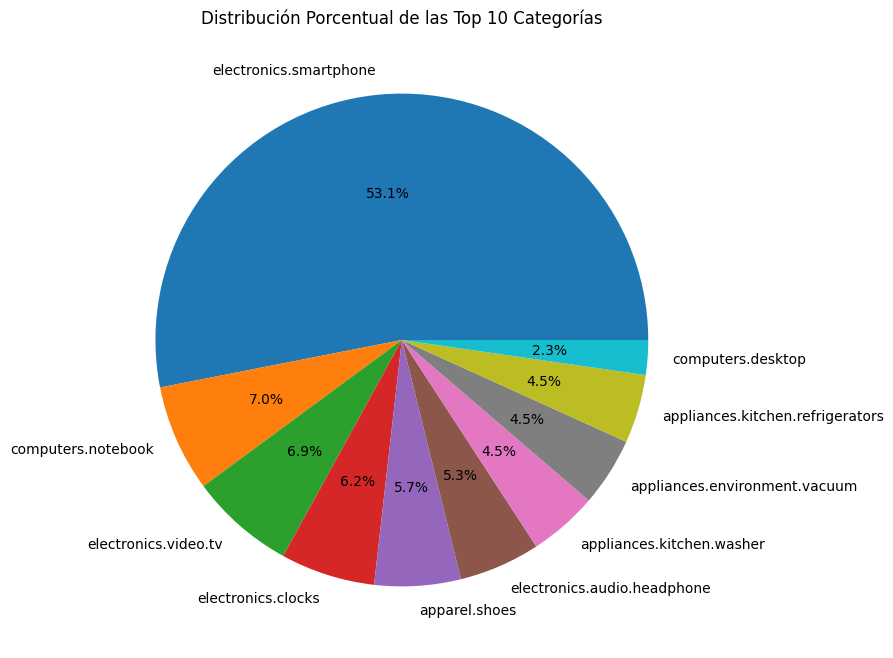

In [15]:
# Análisis de categorías
print("=== ANÁLISIS DE CATEGORÍAS ===")

# Verificar la columna de categoría (podría ser 'category_code' o similar)
categoria_col = 'category_code' if 'category_code' in df.columns else 'category'
print(f"Columna de categoría usada: {categoria_col}")

# Top categorías más populares
top_categorias = df[categoria_col].value_counts().head(15)
print(f"\nTotal de categorías únicas: {df[categoria_col].nunique()}")
print(f"\nTop 15 categorías más populares:")
print(top_categorias)

# Para gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de top categorías
plt.figure(figsize=(12, 6))
top_categorias.plot(kind='bar')
plt.title('Top 15 Categorías de Productos Más Populares')
plt.xlabel('Categoría')
plt.ylabel('Número de Productos/Eventos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Distribución porcentual
plt.figure(figsize=(10, 8))
categorias_porcentaje = df[categoria_col].value_counts(normalize=True).head(10) * 100
plt.pie(categorias_porcentaje.values, labels=categorias_porcentaje.index, autopct='%1.1f%%')
plt.title('Distribución Porcentual de las Top 10 Categorías')
plt.show()


=== ANÁLISIS DE MARCAS ===
Columna de marca usada: brand
Total de marcas únicas: 3808

Top 15 marcas más representadas:
brand
samsung     3561351
apple       2893959
xiaomi      2096970
huawei       634919
lucente      516717
lg           477511
bosch        413906
oppo         375902
acer         339406
sony         338139
cordiant     337468
lenovo       310242
artel        296749
respect      269270
hp           245741
Name: count, dtype: int64

Top 15 marcas más representadas:
brand
samsung     3561351
apple       2893959
xiaomi      2096970
huawei       634919
lucente      516717
lg           477511
bosch        413906
oppo         375902
acer         339406
sony         338139
cordiant     337468
lenovo       310242
artel        296749
respect      269270
hp           245741
Name: count, dtype: int64


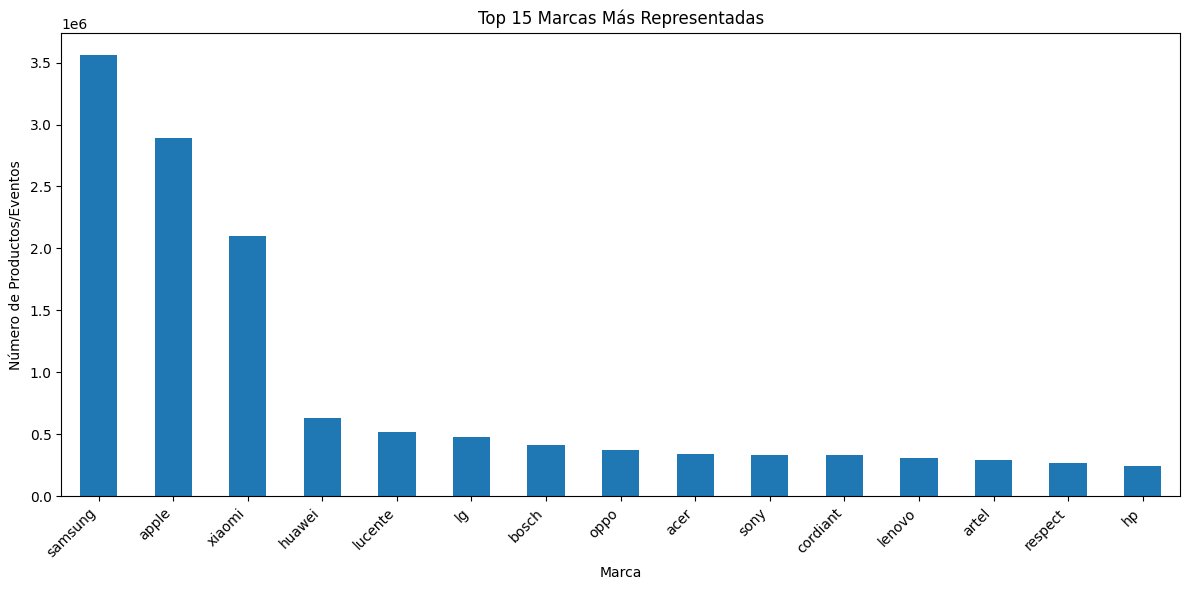


Estadísticas de distribución por marca:
Promedio de productos por marca: 6794.07
Marca con más productos: 3561351
Marca con menos productos: 1


In [16]:
# Análisis de marcas
print("\n=== ANÁLISIS DE MARCAS ===")

# Verificar la columna de marca (podría ser 'brand' o similar)
marca_col = 'brand' if 'brand' in df.columns else 'brand_name'
print(f"Columna de marca usada: {marca_col}")

# Estadísticas de marcas
print(f"Total de marcas únicas: {df[marca_col].nunique()}")

# Top marcas más representadas
top_marcas = df[marca_col].value_counts().head(15)
print(f"\nTop 15 marcas más representadas:")
print(top_marcas)

# Para gráficos
import matplotlib.pyplot as plt

# Gráfico de top marcas
plt.figure(figsize=(12, 6))
top_marcas.plot(kind='bar')
plt.title('Top 15 Marcas Más Representadas')
plt.xlabel('Marca')
plt.ylabel('Número de Productos/Eventos')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Distribución de productos por marca (para ver concentración)
marca_distribution = df[marca_col].value_counts()
print(f"\nEstadísticas de distribución por marca:")
print(f"Promedio de productos por marca: {marca_distribution.mean():.2f}")
print(f"Marca con más productos: {marca_distribution.max()}")
print(f"Marca con menos productos: {marca_distribution.min()}")


=== ANÁLISIS DE PRECIOS ===
Columna de precio usada: price
Estadísticas descriptivas de precios:
count    3.000000e+07
mean     2.978554e+02
std      3.543124e+02
min      0.000000e+00
25%      7.076000e+01
50%      1.699200e+02
75%      3.783600e+02
max      2.574070e+03
Name: price, dtype: float64
count    3.000000e+07
mean     2.978554e+02
std      3.543124e+02
min      0.000000e+00
25%      7.076000e+01
50%      1.699200e+02
75%      3.783600e+02
max      2.574070e+03
Name: price, dtype: float64


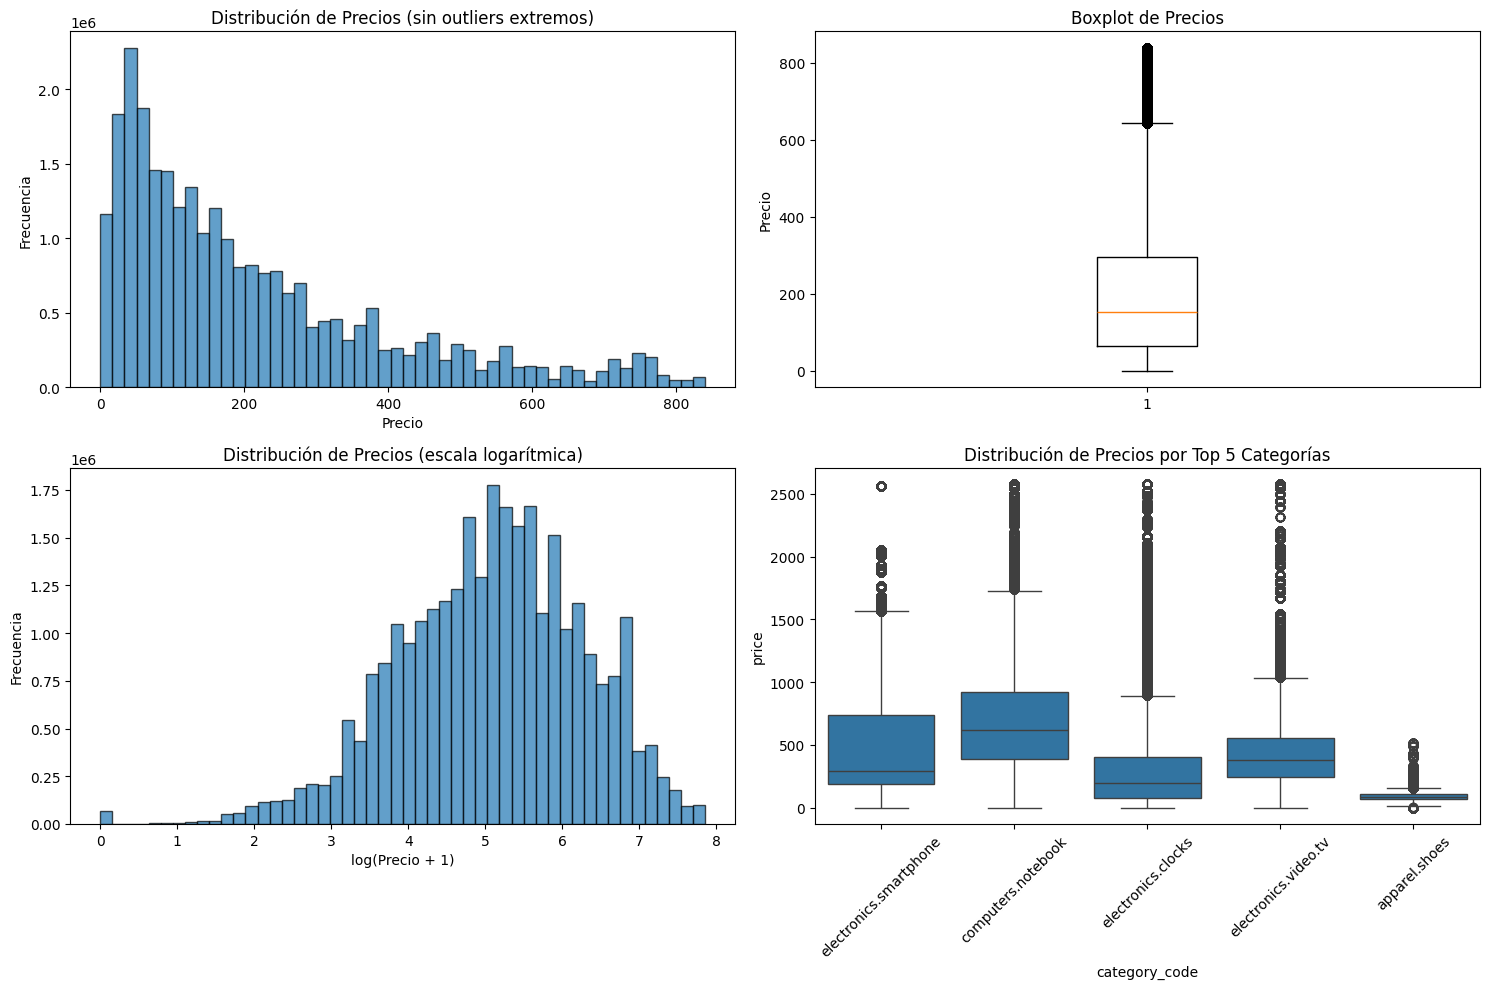


Análisis adicional de precios:
Rango de precios: $0.00 - $2574.07
Rango de precios: $0.00 - $2574.07
Mediana de precios: $169.92
Precio más común (moda): $154.42
Mediana de precios: $169.92
Precio más común (moda): $154.42


In [17]:
# Análisis de precios
print("\n=== ANÁLISIS DE PRECIOS ===")

# Verificar la columna de precio (podría ser 'price' o similar)
precio_col = 'price' if 'price' in df.columns else 'product_price'
print(f"Columna de precio usada: {precio_col}")

# Estadísticas básicas de precios
print(f"Estadísticas descriptivas de precios:")
print(df[precio_col].describe())

# Para gráficos
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Limpiar posibles valores atípicos extremos para mejor visualización
precios_clean = df[precio_col].dropna()
Q1 = precios_clean.quantile(0.25)
Q3 = precios_clean.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

precios_filtrados = precios_clean[(precios_clean >= lower_bound) & (precios_clean <= upper_bound)]

# Gráficos de distribución de precios
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histograma
axes[0,0].hist(precios_filtrados, bins=50, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Distribución de Precios (sin outliers extremos)')
axes[0,0].set_xlabel('Precio')
axes[0,0].set_ylabel('Frecuencia')

# Boxplot
axes[0,1].boxplot(precios_filtrados)
axes[0,1].set_title('Boxplot de Precios')
axes[0,1].set_ylabel('Precio')

# Distribución de precios en escala logarítmica (si hay mucha variabilidad)
if len(precios_clean) > 0 and (precios_clean.max() > 0) and (precios_clean.max() / max(precios_clean.min(), 1e-9) > 100):  # evitar división por 0
    axes[1,0].hist(np.log1p(precios_clean), bins=50, alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Distribución de Precios (escala logarítmica)')
    axes[1,0].set_xlabel('log(Precio + 1)')
    axes[1,0].set_ylabel('Frecuencia')
else:
    axes[1,0].axis('off')

# Precios por categoría (top 5 categorías)
top_5_categorias = df[categoria_col].value_counts().head(5).index
precios_por_categoria = df[df[categoria_col].isin(top_5_categorias)]
if not precios_por_categoria.empty:
    sns.boxplot(data=precios_por_categoria, x=categoria_col, y=precio_col, ax=axes[1,1])
    axes[1,1].set_title('Distribución de Precios por Top 5 Categorías')
    axes[1,1].tick_params(axis='x', rotation=45)
else:
    axes[1,1].axis('off')

plt.tight_layout()
plt.show()

# Análisis adicional de precios
print(f"\nAnálisis adicional de precios:")
print(f"Rango de precios: ${precios_clean.min():.2f} - ${precios_clean.max():.2f}")
print(f"Mediana de precios: ${precios_clean.median():.2f}")
print(f"Precio más común (moda): ${precios_clean.mode().iloc[0] if not precios_clean.mode().empty else 'N/A'}")